## Using `xarray.apply_ufunc` to apply a function to every gridpoint

When you need to compute something separately at many gridpoints, especially if it is fast at a single gridpoint, putting this computation into a for loop can be very slow. Instead, it is prefereable to vectorise a function, so that the numpy and/or dask backend can distribute the work across multiple cores.

That is, to find the mean at each location, with an xarray dataset with dimensions `lon`, `lat`, and `time` instead of

```python
out = np.zeros(N, M)
for i in range(N):
    for j in range(M):
        out[i, j] = data.isel(lon=i, lat=j).mean()
```
we write:

```python
out = data.mean(dim=('time'))
```
which would tell xarray to take the mean in the time dimension for every one of the gridpoints.

Some functions, such as ```scipy.stats.linregress```, do not have in-build vectorisation, but you might want to apply a function like this to every gridpoint, and for loops would be slow. 

This notebook **provides a few examples of how to apply functions which do not natively vectorise many times to an xarray dataset, vectorised so that a dask client can speed up the calculation**. We answer here a dummy question "What is sea-surface temperature trend at each gridpoint of an ocean model, and is it significant?". Scientifically, this question mostly applies to the forcing dataset and not the ocean model, but it's as good an example as any.**

To achieve this goal, we use ```xarray.apply_ufunc```, which is very versatile, but therefore takes many arguments that can be difficult to interpret at first glance. The aim of the example below is to give something that will work on a problem similar to what COSIMA users may encounter.

For full documentation of ```xarray.apply_ufunc``` refer to: https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html

Code takes about 5 minutes total on 4 cores

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import scipy.stats

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1, memory_limit=0)
client

<Client: 'tcp://127.0.0.1:46407' processes=48 threads=48>

In [3]:
# Get some data
session = cc.database.create_session()
experiment = '025deg_jra55_iaf_omip2_cycle6'
sst = cc.querying.getvar(experiment, 'sst', session, frequency='1 monthly', chunks={})

In [4]:
# Rechunk so that there is only one chunk in time dimension, used by the linear regression
sst = sst.chunk({'time': -1}) 

In [5]:
# Make a function that takes the data we have and returns what we want
def get_trend(time, timeseries):
    '''Calculate the trend through a timeseries using scipy.stats.linregress, 
    and return just the slope and p value as an array, for the purposes of 
    demonstrating xarray.apply_ufunc

    Inputs:
        time: np.ndarray
            the times or x values of whatever the slope will go through
        timeseries: np.ndarray
            the data to calculate the slope of

    Outputs:
        stats: np.ndarray
            1st element is the trend in timeseries
            2nd element is the p_value of this trend, indicating the significance
            They're lumped together into one variable, a) so .load() can be called 
            on both at once, and b) to demonstrate some of the nuance in xr.apply_ufunc
            when using it for more complicated applications
    '''

    slope, intercept, r, p, se = scipy.stats.linregress(time, timeseries)
    return np.array((slope, p)) # Combine into one array because it's easier to load in one go

In [6]:
# Define a timeseries for the linear regression to work (because scipy doesn't like datetimes)
#     (This line is specific to the function being applied - in this instance, we want to apply 
#     scipy.stats.linregress, and it needs a timeseries of x values so we make it one)

years_since_start = xr.DataArray(np.arange(sst.time.shape[0])/12,
                                 dims=('time',),
                                 coords={'time': sst.time})

#Pass data through to the `xarray.apply_ufunc`
stats = xr.apply_ufunc(get_trend,                               # function being used
                       years_since_start,                       # Argument 1 for function
                       sst,                                     # Argument 2 for function
                       input_core_dims=(('time',), ('time',)),  # Dimensions the function needs for each argument
                       output_core_dims=(('stat_type',),),      # Dimensions of each output from the function
                       output_sizes={'stat_type': 2},           # The new dimension will have size 2
                       vectorize=True,                          # The function needs to only have one lat and lon at a time
                       dask = 'parallelized',                   # Dask is fine, but the function can't handle it so apply_ufunc needs to
                       )

This last function call is roughly equivalent to

```python
stats = np.zeros(2, len(sst.xt_ocean), len(sst.yt_ocean))

for i in range(len(sst.xt_ocean)):
    for j in range(len(sst.yt_ocean)):
        slope,intercept = get_trend(years_since_start, sst.isel(xt_ocean=i, yt_ocean=j)
        stats[0, i, j] = slope
        stats[1, i, j] = intercept
```
But the loading step (next cell) should be faster than this computation in a for loop

In [7]:
%time stats.load()
# Put data back into some more useful variable names
sst_trend = stats.sel(stat_type=0)
p_value = stats.sel(stat_type=1)

CPU times: user 25.2 s, sys: 1.7 s, total: 26.9 s
Wall time: 32.1 s


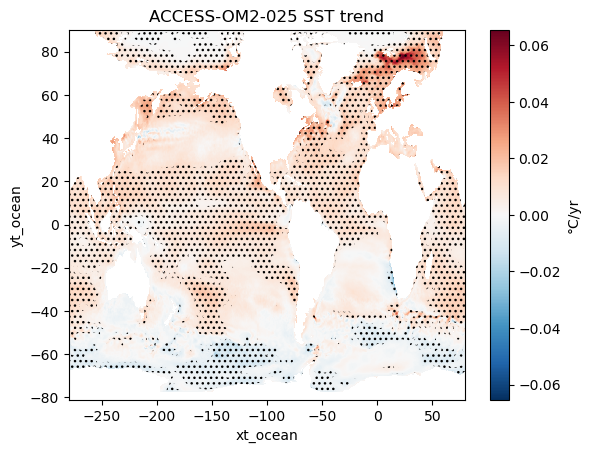

In [8]:
# Plot the calculated slope, stippling all regions that are significant at p<0.05
sst_trend.plot(cbar_kwargs={'label': '°C/yr'})
plt.contourf(p_value.xt_ocean, p_value.yt_ocean, p_value,
             levels=(0, 0.05), colors='None', hatches=('...',))
plt.title('ACCESS-OM2-025 SST trend');